LICENSE: Could not open license file "oe_license.txt" in local directory
LICENSE: N.B. OE_LICENSE environment variable is not set
LICENSE: N.B. OE_DIR environment variable is not set
LICENSE: No product keys!
LICENSE: No product keys!
LICENSE: No product keys!
LICENSE: No product keys!


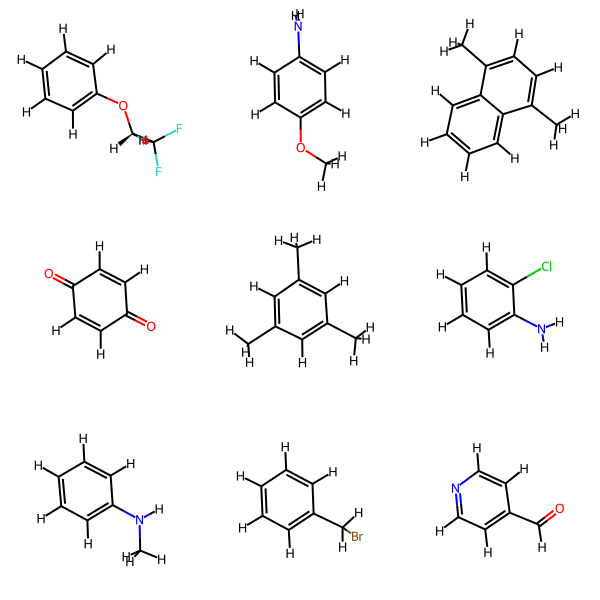

In [1]:
from rdkit import Chem
from openfe_benchmarks import benzenes
from kartograf import KartografAtomMapper
from openfe.setup.atom_mapping.lomap_scorers import default_lomap_score

system=benzenes.get_system()
compounds = system.ligand_components
compounds = compounds[7:]
Chem.Draw.MolsToGridImage ([c.to_rdkit() for c in compounds], )

In [29]:
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt

def draw_ligand_network(network, title=""):
    ligands = list(network.nodes)
    edge_map = {(m.componentA.name, m.componentB.name): m for m in network.edges}
    edges = list(sorted(edge_map.keys()))
    weights = [edge_map[k].annotations['score'] for k in edges]

    g = nx.Graph()
    [g.add_node(n.name) for n in ligands]
    g.add_weighted_edges_from(ebunch_to_add=[(e[0], e[1], w) for e,w in zip(edges,weights)])


    fig, axes = plt.subplots(ncols=1, nrows=1, figsize=[16,9])
    axes = np.array(axes, ndmin=1)
    nx.draw_networkx(g, with_labels=True, ax=axes[0])

    axes[0].set_title("Ligand Network Graph - "+title+" #edges "+str(len(g.edges)))
    return fig

# Radial Network Layout

In [30]:
from konnektor.network_planner import RadialLigandNetworkPlanner
ligand_network_planner = RadialLigandNetworkPlanner(mapper=KartografAtomMapper(), scorer=default_lomap_score)

In [31]:
network = ligand_network_planner(compounds)
network

[[0, 6, 0.36237184837822667], [1, 6, 0.3934693402873666], [2, 6, 0.7134952031398099], [3, 6, 0.3296799539643607], [4, 6, 0.29531191028128656], [5, 6, 0.18126924692201818], [6, 7, 0.22119921692859512], [6, 8, 0.3623718483782268]]
[LigandAtomMapping(componentA=SmallMoleculeComponent(name=lig_8), componentB=SmallMoleculeComponent(name=lig_14), componentA_to_componentB={1: 10, 13: 9, 14: 12, 15: 13, 16: 14, 17: 15, 18: 16, 3: 0, 5: 1, 6: 2, 7: 3, 8: 4, 9: 5, 10: 6, 11: 7}, annotations={'score': 0.36237184837822667}), LigandAtomMapping(componentA=SmallMoleculeComponent(name=lig_9), componentB=SmallMoleculeComponent(name=lig_14), componentA_to_componentB={1: 12, 6: 15, 12: 1, 13: 16, 16: 14, 17: 13, 2: 3, 3: 2, 4: 7, 5: 6, 7: 5, 8: 4}, annotations={'score': 0.3934693402873666}), LigandAtomMapping(componentA=SmallMoleculeComponent(name=lig_10), componentB=SmallMoleculeComponent(name=lig_14), componentA_to_componentB={13: 11, 15: 16, 16: 15, 0: 1, 1: 2, 2: 7, 3: 6, 4: 5, 6: 4, 11: 3}, annotati

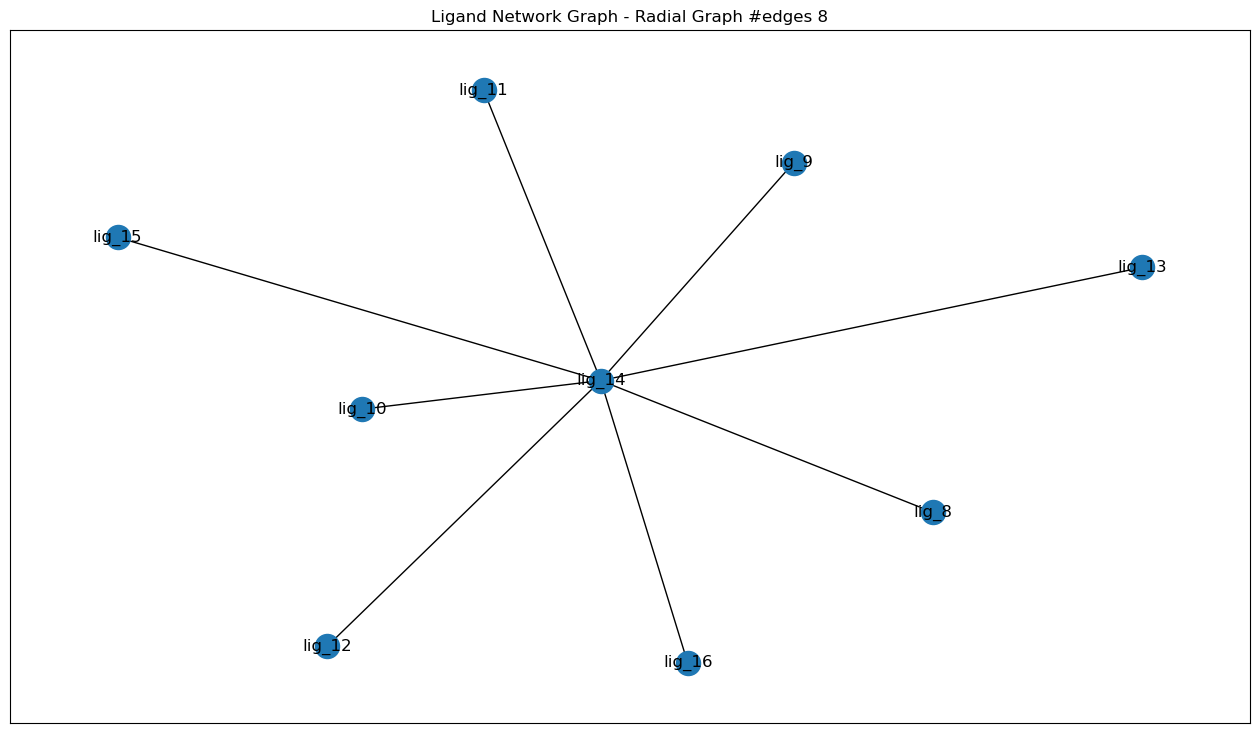

In [33]:
draw_ligand_network(network, title="Radial Graph");

# Minimal Spanning Tree

In [34]:
from konnektor.network_planner import MinimalSpanningTreeLigandNetworkPlanner

ligand_network_planner = MinimalSpanningTreeLigandNetworkPlanner(mapper=KartografAtomMapper(), scorer=default_lomap_score)

In [35]:
network = ligand_network_planner(compounds)
network

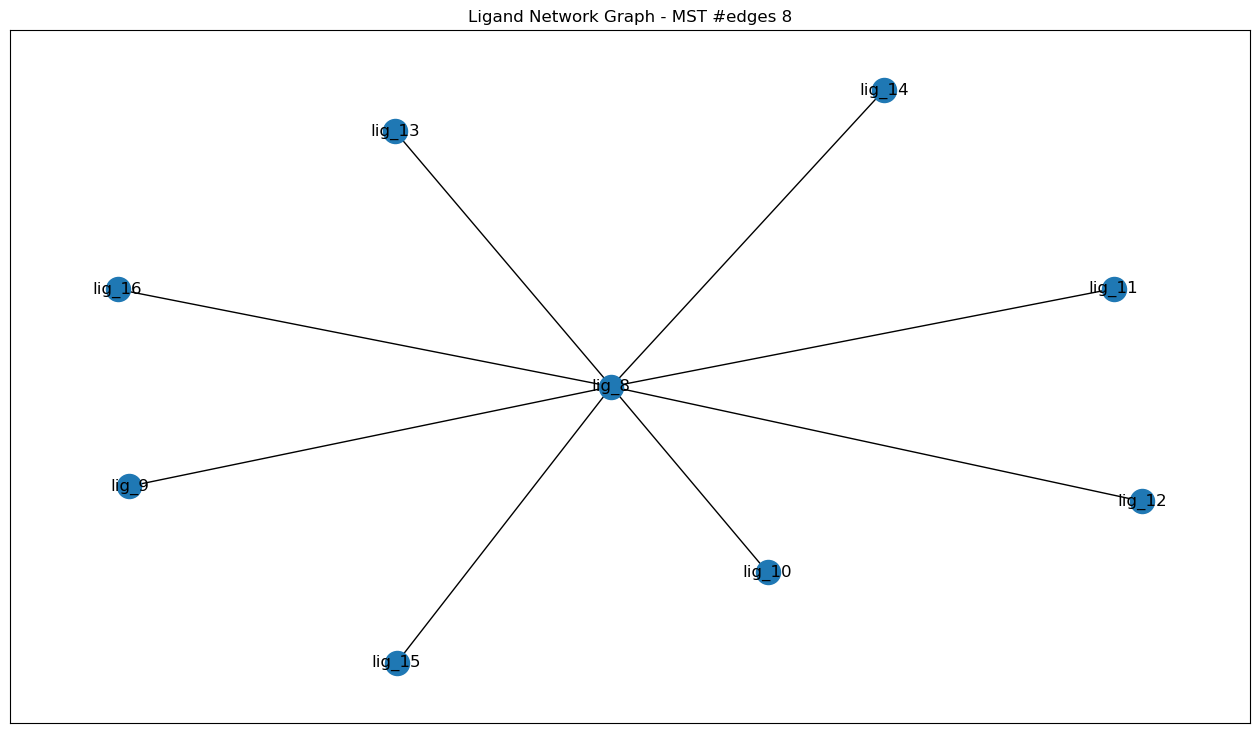

In [36]:
draw_ligand_network(network, "MST");

# Cyclo Graphs

In [37]:
from konnektor.network_planner import CyclicLigandNetworkPlanner
ligand_network_planner = CyclicLigandNetworkPlanner(mapper=KartografAtomMapper(), scorer=default_lomap_score,
                                                    cycle_sizes=3, node_present_in_cycles=2)

In [38]:
network = ligand_network_planner(compounds)
network

ERROR:	
Timings:
--------
ERROR:		 Cycle generation duration: 0:00:00.015310
ERROR:		 Cycle selection duration: 0:00:00.000367
ERROR:		 total duration: 0:00:00.015995


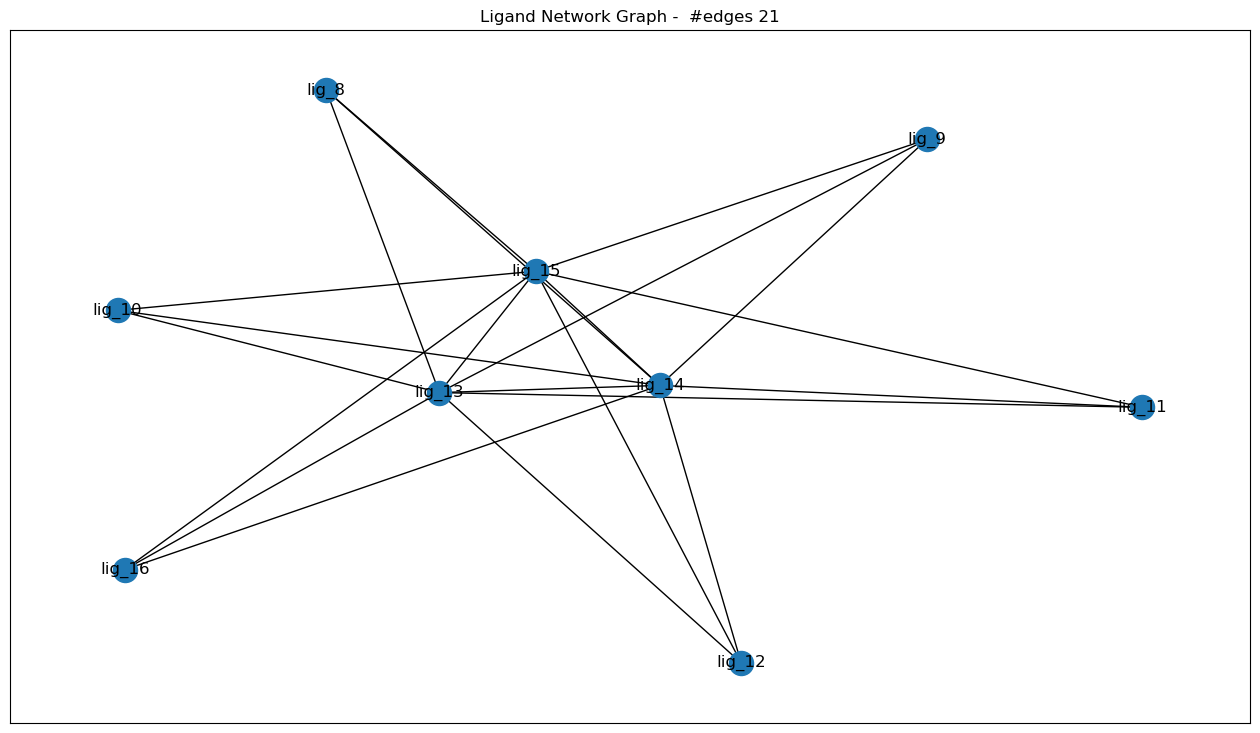

In [39]:
draw_ligand_network(network);

Text(0.5, 0.98, 'Algorithm I')

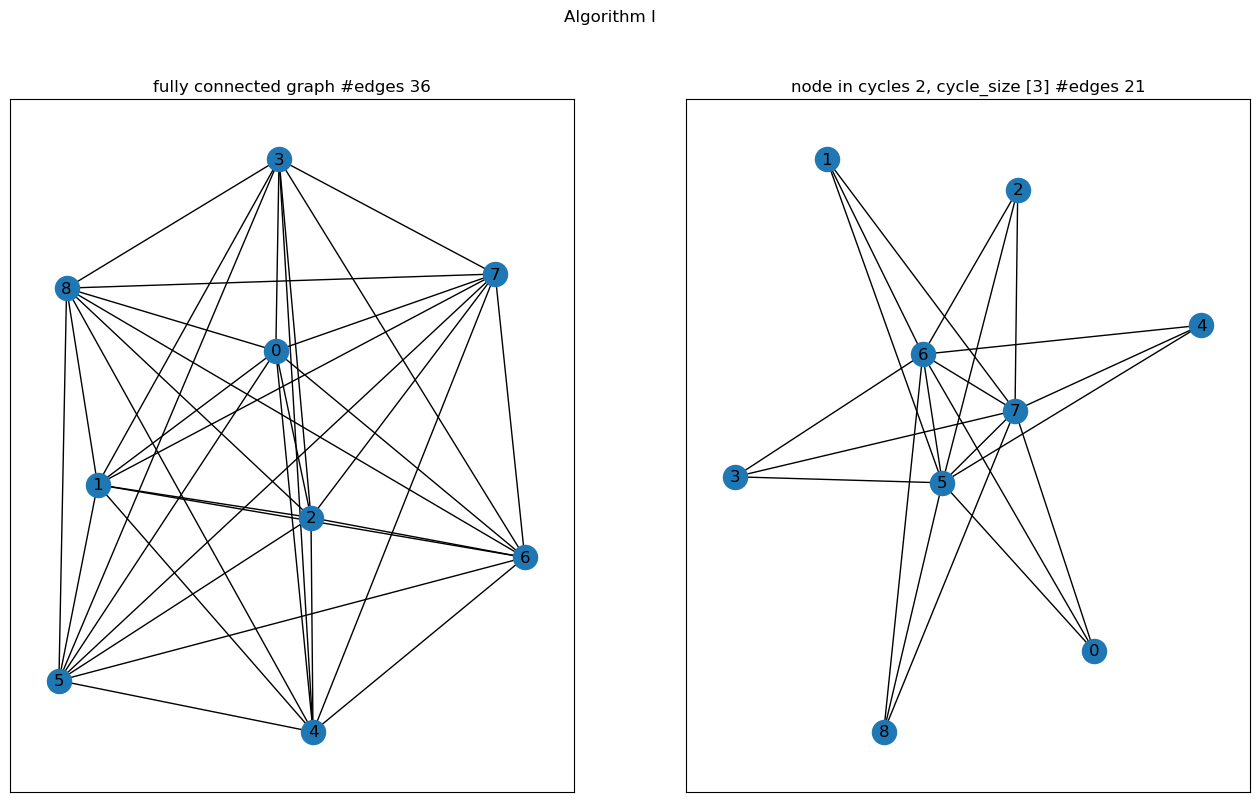

In [40]:
import networkx as nx
from matplotlib import pyplot as plt

ng=ligand_network_planner.network_generator
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=[16,9])
nx.draw_networkx(ng.orig_g, with_labels=True, ax=axes[0])
nx.draw_networkx(ng.cyclic_graph, with_labels=True, ax=axes[1])


axes[0].set_title("fully connected graph"+" #edges "+str(len(ng.orig_g.edges)))
axes[1].set_title("node in cycles "+str(ng.node_cycle_connectivity)+", cycle_size "+str(ng.sub_cycle_size_range)+" #edges "+str(len(ng.cyclic_graph.edges)))
fig.suptitle("Algorithm I")

# Maximally connected network

In [41]:
from konnektor.network_planner import MaximalNetworkPlanner
ligand_network_planner = MaximalNetworkPlanner(mapper=KartografAtomMapper(), scorer=default_lomap_score)

In [42]:
network = ligand_network_planner(compounds)
network

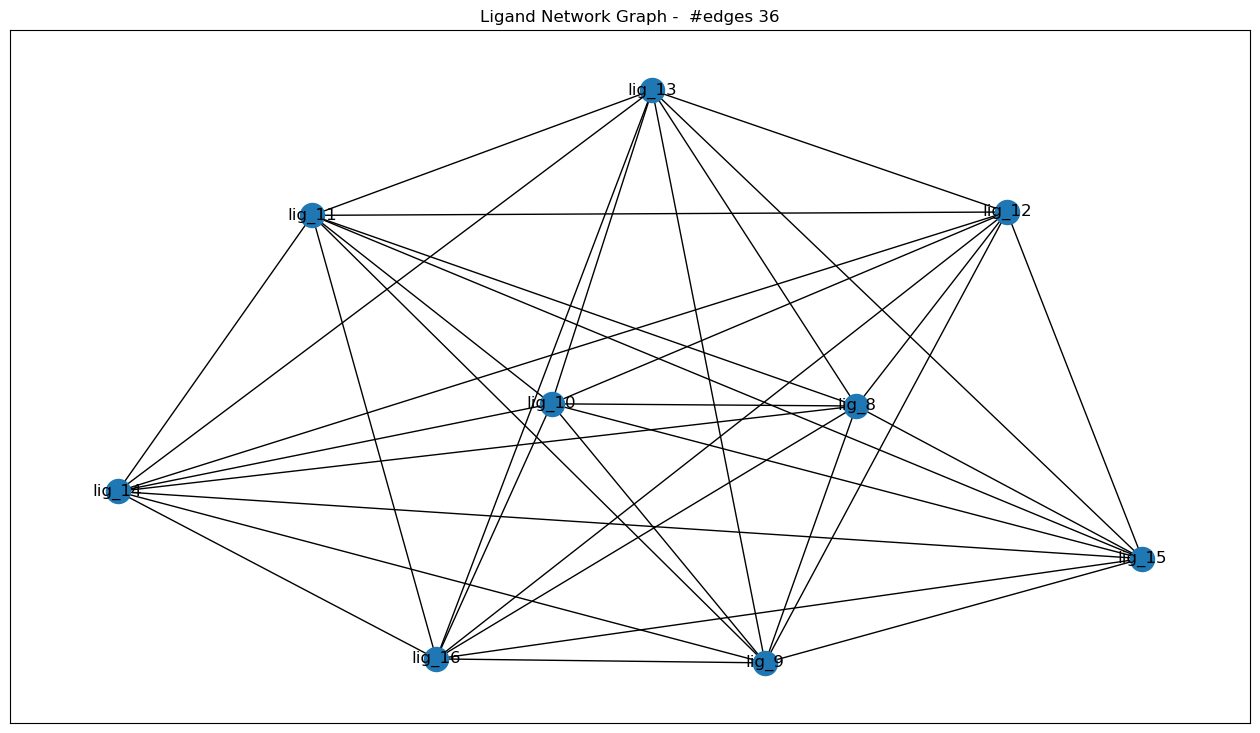

In [44]:
draw_ligand_network(network);